In [2]:
!pip install tensorflow opencv-python matplotlib seaborn plotly scikit-learn pandas --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
!pip install tensorflow opencv-python matplotlib seaborn plotly scikit-learn pandas kaleido --quiet


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import plotly.graph_objects as go
import json
from pathlib import Path

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Global constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# Project paths
DATASET_PATH = "DATASET"
OUTPUT_DIR = "output"

In [13]:
# Create output directory if it doesn't exist
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Validate dataset path
if not os.path.exists(DATASET_PATH):
    raise ValueError(f"Dataset directory not found at {DATASET_PATH}")

print("✅ Configuration validated successfully")
print(f"Dataset path: {os.path.abspath(DATASET_PATH)}")
print(f"Output directory: {os.path.abspath(OUTPUT_DIR)}")

✅ Configuration validated successfully
Dataset path: c:\Users\nimba_7qa63ab\Desktop\Project\DATASET
Output directory: c:\Users\nimba_7qa63ab\Desktop\Project\output


In [14]:
def validate_image(image_path):
    """Validate if an image file can be opened and read"""
    try:
        img = cv2.imread(image_path)
        return img is not None
    except Exception:
        return False

# Get class directories
class_dirs = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
if not class_dirs:
    raise ValueError("No class directories found in dataset path")

print(f"Found {len(class_dirs)} classes: {class_dirs}\n")

# Validate images in each class
invalid_images = []
for class_name in class_dirs:
    class_path = os.path.join(DATASET_PATH, class_name)
    print(f"Checking {class_name}...")
    
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for img_file in image_files:
        img_path = os.path.join(class_path, img_file)
        if not validate_image(img_path):
            invalid_images.append(img_path)
            print(f"❌ Invalid/corrupt image: {img_path}")
            
if invalid_images:
    print(f"\n⚠️ Found {len(invalid_images)} invalid images")
else:
    print("\n✅ All images are valid")

Found 4 classes: ['clear skin', 'dark spots', 'puffy eyes', 'wrinkles']

Checking clear skin...
Checking dark spots...
Checking dark spots...
Checking puffy eyes...
Checking puffy eyes...
Checking wrinkles...
Checking wrinkles...

✅ All images are valid

✅ All images are valid


In [15]:
# Count images per class
image_counts = {}
for class_name in class_dirs:
    class_path = os.path.join(DATASET_PATH, class_name)
    count = len([f for f in os.listdir(class_path) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    image_counts[class_name] = count
    print(f"{class_name}: {count} images")

# Save counts to JSON
counts_file = os.path.join(OUTPUT_DIR, "class_counts.json")
with open(counts_file, 'w') as f:
    json.dump(image_counts, f, indent=4)

print(f"\n✅ Saved class counts to {counts_file}")

clear skin: 300 images
dark spots: 301 images
puffy eyes: 300 images
wrinkles: 300 images

✅ Saved class counts to output\class_counts.json


In [13]:
# 3️⃣ Plot distribution (Deliverable 1)
fig = go.Figure([go.Bar(x=list(image_counts.keys()), y=list(image_counts.values()))])
fig.update_layout(
    title="Milestone 1 Deliverable 1 — Class Distribution Plot",
    xaxis_title="Class Name",
    yaxis_title="Number of Images",
)
fig.show()

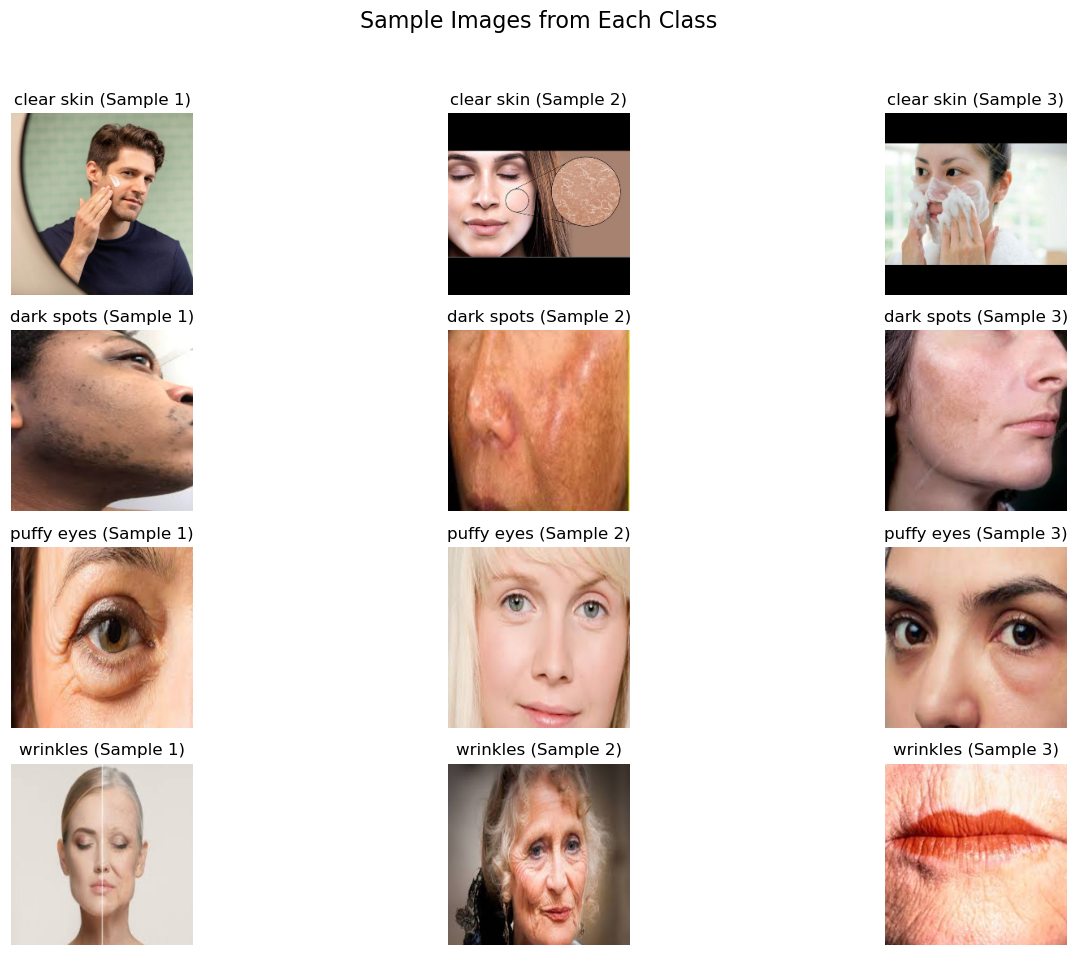


✅ Saved sample images visualization to output\sample_images.png


In [17]:
# Create a figure to display sample images
plt.figure(figsize=(15, 10))
plt.suptitle("Sample Images from Each Class", fontsize=16)

for i, class_name in enumerate(class_dirs):
    class_path = os.path.join(DATASET_PATH, class_name)
    samples = [f for f in os.listdir(class_path) 
              if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:3]
    
    for j, img_name in enumerate(samples):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        
        plt.subplot(len(class_dirs), 3, i * 3 + j + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{class_name} (Sample {j+1})")
        plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
samples_file = os.path.join(OUTPUT_DIR, "sample_images.png")
plt.savefig(samples_file)
plt.show()

print(f"\n✅ Saved sample images visualization to {samples_file}")

In [18]:
# Configure data generators
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# Validation generator with only preprocessing (no augmentation)
validation_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=VALIDATION_SPLIT
)

print("✅ Data generators configured with:")
print("Training augmentations:")
print("- Rotation: ±30°")
print("- Width/Height shift: ±20%")
print("- Zoom: ±20%")
print("- Horizontal flip: Yes")
print("- Validation split:", VALIDATION_SPLIT)

✅ Data generators configured with:
Training augmentations:
- Rotation: ±30°
- Width/Height shift: ±20%
- Zoom: ±20%
- Horizontal flip: Yes
- Validation split: 0.2


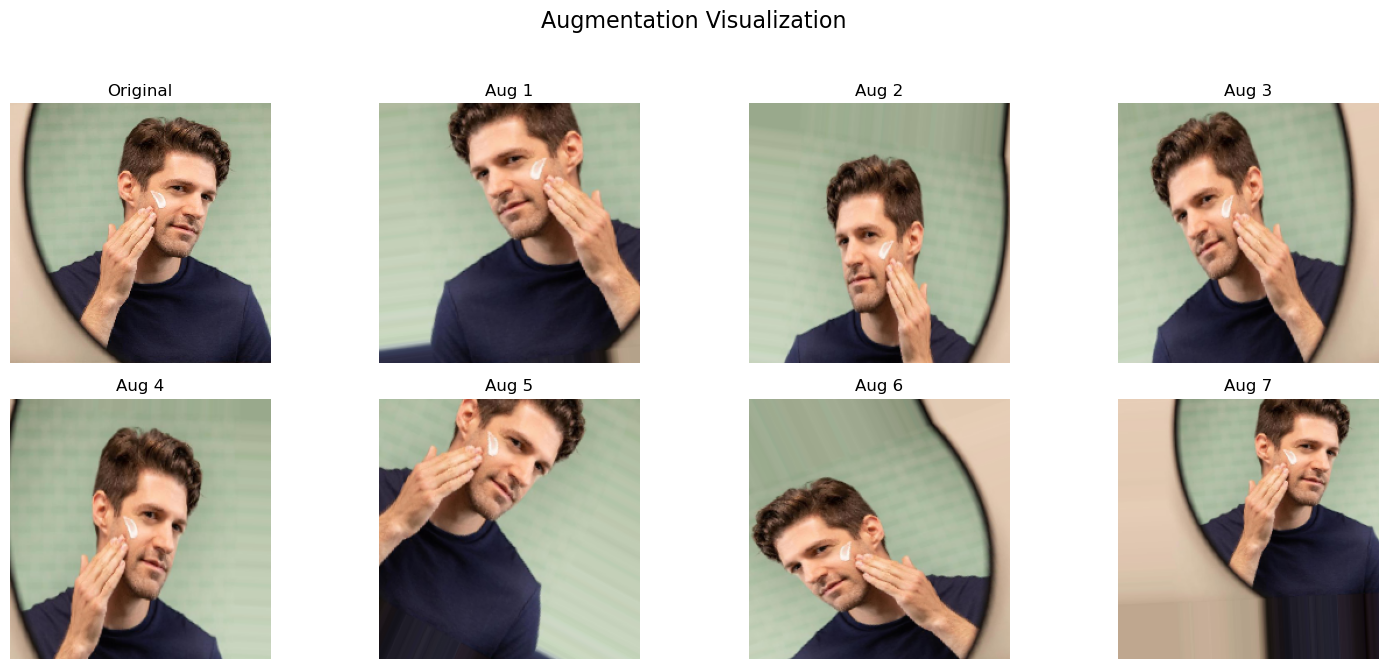


✅ Saved augmentation visualization to output\augmentation_examples.png


In [19]:
# Get a sample image from the first class
first_class = class_dirs[0]
first_path = os.path.join(DATASET_PATH, first_class)
img_name = [f for f in os.listdir(first_path) 
           if f.lower().endswith(('.jpg', '.png', '.jpeg'))][0]
img_path = os.path.join(first_path, img_name)

# Load and preprocess the image
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Create augmentation iterator
aug_iter = train_datagen.flow(img_array, batch_size=1)

# Plot original and augmented versions
plt.figure(figsize=(15, 7))
plt.suptitle("Augmentation Visualization", fontsize=16)

# Plot original
plt.subplot(2, 4, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# Plot augmented versions
for i in range(7):
    aug_img = next(aug_iter)[0]
    plt.subplot(2, 4, i + 2)
    plt.imshow(aug_img.astype(np.uint8))
    plt.title(f"Aug {i+1}")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the visualization
aug_file = os.path.join(OUTPUT_DIR, "augmentation_examples.png")
plt.savefig(aug_file)
plt.show()

print(f"\n✅ Saved augmentation visualization to {aug_file}")

In [20]:
# Create training generator
print("Creating training generator...")
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

print("\nCreating validation generator...")
validation_generator = validation_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("\n✅ Data Generators Ready:")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Steps per epoch: {train_generator.samples // BATCH_SIZE}")
print(f"Validation steps: {validation_generator.samples // BATCH_SIZE}")
print("\nClass indices:", train_generator.class_indices)

# Save class indices for later use
class_indices_file = os.path.join(OUTPUT_DIR, "class_indices.json")
with open(class_indices_file, 'w') as f:
    json.dump(train_generator.class_indices, f, indent=4)

print(f"\n✅ Saved class indices to {class_indices_file}")

Creating training generator...
Found 961 images belonging to 4 classes.

Creating validation generator...
Found 240 images belonging to 4 classes.

✅ Data Generators Ready:
Training samples: 961
Validation samples: 240
Steps per epoch: 30
Validation steps: 7

Class indices: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}

✅ Saved class indices to output\class_indices.json

Creating validation generator...
Found 240 images belonging to 4 classes.

✅ Data Generators Ready:
Training samples: 961
Validation samples: 240
Steps per epoch: 30
Validation steps: 7

Class indices: {'clear skin': 0, 'dark spots': 1, 'puffy eyes': 2, 'wrinkles': 3}

✅ Saved class indices to output\class_indices.json
